# Examples of Stacking BOSS Spectra using Speclite

Examples of using the [speclite](http://speclite.readthedocs.org/) package to perform basic operations on spectral data accessed with the [bossdata](http://bossdata.readthedocs.org/) package.  To keep the examples small, we use data from a single BOSS plate (6641 observed on MJD 56383) and show how to work with both the individual spec-lite files and the combined spPlate file (see [here](https://bossdata.readthedocs.org/en/latest/overview.html) for details on the different data products).

## Package Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import speclite
print(speclite.version.version)

0.8dev479


In [3]:
import bossdata
print(bossdata.__version__)

0.3.0dev


In [4]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

## Stacked Sky

Get a list of sky spectra on plate 6641:

In [5]:
spAll = bossdata.meta.Database(lite=True)

In [6]:
sky_table = spAll.select_all(where='PLATE=6641 and OBJTYPE="SKY"')
print('Found {0} sky fibers for plate 6641.'.format(len(sky_table)))

Found 83 sky fibers for plate 6641.


Plot a stacked spectrum:

In [7]:
def plot_stack(data, truncate_percentile):
    valid = data['ivar'] > 0
    wlen = data['wavelength'][valid]
    flux = data['flux'][valid]
    dflux = data['ivar'][valid]**(-0.5)
    plt.figure(figsize=(12,5))
    plt.fill_between(wlen, flux, lw=0, color='red')
    plt.errorbar(wlen, flux, dflux, color='black', alpha=0.5, ls='None', capthick=0)
    plt.xlim(np.min(wlen), np.max(wlen))
    plt.ylim(0, np.percentile(flux + dflux, truncate_percentile))
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux $10^{-17}$ erg/(s cm$^2 \AA$)')
    plt.tight_layout();

#### Stack individual Spec-lite files

Loop over all sky spectra on the plate.  The necessary spec-lite files will be automatically downloaded, if necessary, which will take several minutes.

In [8]:
spec_sky = None
for row in sky_table:
    filename = finder.get_spec_path(plate=row['PLATE'], mjd=row['MJD'], fiber=row['FIBER'], lite=True)
    spectrum = bossdata.spec.SpecFile(mirror.get(filename))
    data = spectrum.get_valid_data(include_sky=True, use_ivar=True, fiducial_grid=True)
    spec_sky = speclite.accumulate(spec_sky, data, data_out=spec_sky, join='wavelength',
                                   add=('flux', 'sky'), weight='ivar')
spec_sky['flux'] += spec_sky['sky']

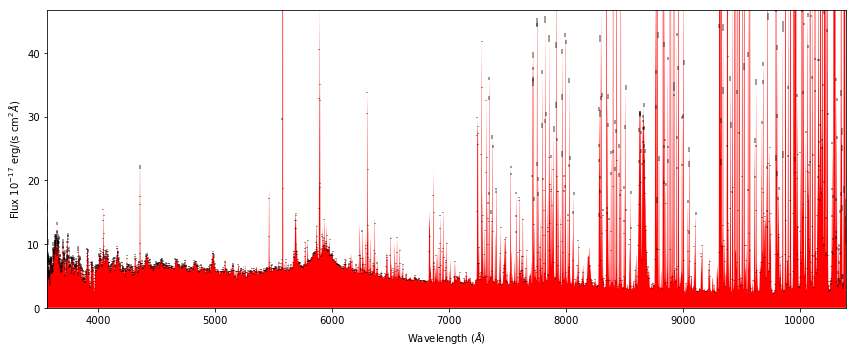

In [9]:
plot_stack(spec_sky, truncate_percentile=97.5)

#### Stack Spectra from one Plate file

Accumulate the sky spectra from a Plate file, which will be automatically downloaded if necessary.

In [10]:
plate_sky = None
filename = finder.get_plate_spec_path(plate=6641, mjd=56383)
plate = bossdata.plate.PlateFile(mirror.get(filename))
plate_data = plate.get_valid_data(sky_table['FIBER'], include_sky=True, use_ivar=True, fiducial_grid=True)
for data in plate_data:
    plate_sky = speclite.accumulate(plate_sky, data, data_out=plate_sky, join='wavelength',
                                    add=('flux', 'sky'), weight='ivar')
plate_sky['flux'] += plate_sky['sky']

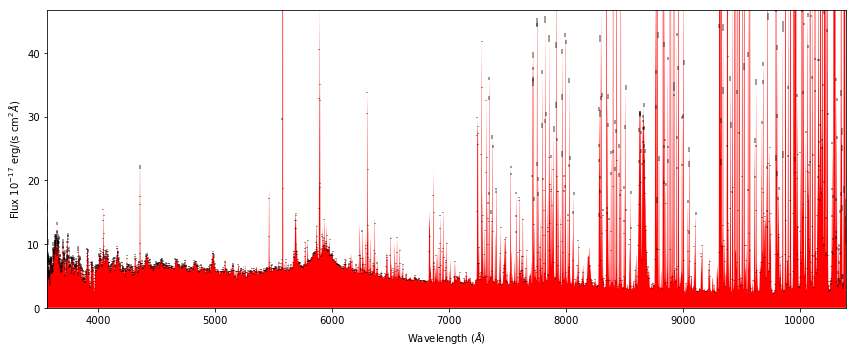

In [11]:
plot_stack(plate_sky, truncate_percentile=97.5)

## Stacked Quasars

Get a list of sky spectra on plate 6641, observed on MJD 56383:

In [12]:
DR12Q = bossdata.meta.Database(finder, mirror, quasar_catalog=True)

In [13]:
qso_table = DR12Q.select_all(where='PLATE=6641 and ZWARNING=0', what='PLATE,MJD,FIBER,Z_VI')
print('Found {0} QSO targets for plate 6641.'.format(len(qso_table)))

Found 132 QSO targets for plate 6641.


Plot the redshift distribution of the selected quasars:

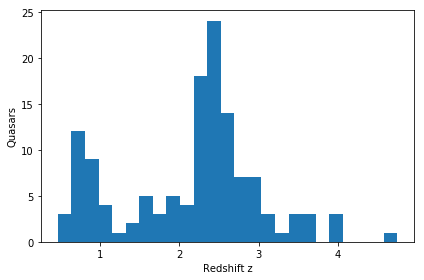

In [14]:
plt.hist(qso_table['Z_VI'], bins=25);
plt.xlabel('Redshift z')
plt.ylabel('Quasars')
plt.tight_layout();

#### Stack spectra from individual Spec-lite files

Loop over all quasar spectra on the plate. The necessary spec-lite files will be automatically downloaded, if necessary, which will take several minutes.

In [15]:
fiducial_grid = np.arange(1000.,3000.)
rest_frame, resampled, spec_qso = None, None, None
for row in qso_table:
    filename = finder.get_spec_path(plate=row['PLATE'], mjd=row['MJD'], fiber=row['FIBER'], lite=True)
    spectrum = bossdata.spec.SpecFile(mirror.get(filename))
    data = spectrum.get_valid_data(use_ivar=True, fiducial_grid=True)
    rest_frame = speclite.redshift(z_in=row['Z_VI'], z_out=0, data_in=data, data_out=rest_frame, rules=[
        dict(name='wavelength', exponent=+1),
        dict(name='flux', exponent=-1),
        dict(name='ivar', exponent=+2)])
    resampled = speclite.resample(rest_frame, x_in='wavelength', x_out=fiducial_grid, y=('flux', 'ivar'),
                                  data_out=resampled)
    spec_qso = speclite.accumulate(spec_qso, resampled, data_out=spec_qso, join='wavelength',
                                   add='flux', weight='ivar')

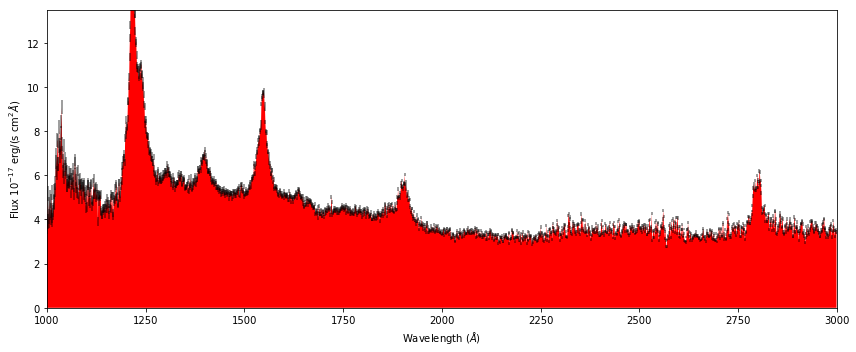

In [16]:
plot_stack(spec_qso, truncate_percentile=99.5)

#### Stack spectra from one Plate file

In [17]:
filename = finder.get_plate_spec_path(plate=6641, mjd=56383)
plate = bossdata.plate.PlateFile(mirror.get(filename))
plate_data = plate.get_valid_data(qso_table['FIBER'], use_ivar=True, fiducial_grid=True)
zorder = np.argsort(qso_table['Z_VI'])

Transform each spectrum to its quasar rest frame.  We perform this operation in place (re-using the memory of the input array) and in parallel on all spectra.

In [18]:
z_in = qso_table['Z_VI'][:,np.newaxis]
plate_data = speclite.redshift(z_in=z_in, z_out=0, data_in=plate_data, data_out=plate_data, rules=[
        dict(name='wavelength', exponent=+1),
        dict(name='flux', exponent=-1),
        dict(name='ivar', exponent=+2)
    ])

Resample each spectrum to a uniform rest wavelength grid and stack them together to calculate the mean rest-frame quasar spectrum.  The resample() and accumulate() operations re-use the same memory for each input spectrum, so this loop has fixed (small) memory requirements, independent of the number of spectra being stacked.

In [19]:
resampled, plate_qso = None, None
for data in plate_data:
    resampled = speclite.resample(data, x_in='wavelength', x_out=fiducial_grid, y=('flux', 'ivar'), data_out=resampled)
    plate_qso = speclite.accumulate(spec_qso, resampled, data_out=plate_qso, join='wavelength',
                                   add='flux', weight='ivar')

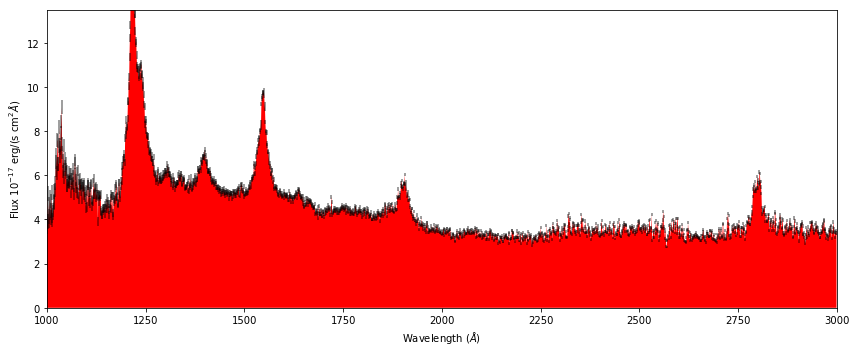

In [20]:
plot_stack(plate_qso, truncate_percentile=99.5)